In [3]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, mean_squared_error, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from joblib import dump, load

In [4]:
df = pd.read_excel('credit_rating.xls')

df = df.drop(columns=['S.No'])
df = df.drop(columns=['S.No.'])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CHK_ACCT                1000 non-null   object
 1   Duration                1000 non-null   int64 
 2   History                 1000 non-null   object
 3   Purpose of credit       1000 non-null   object
 4   Credit Amount           1000 non-null   int64 
 5   Balance in Savings A/C  1000 non-null   object
 6   Employment              1000 non-null   object
 7   Install_rate            1000 non-null   int64 
 8   Marital status          1000 non-null   object
 9   Co-applicant            1000 non-null   object
 10  Present Resident        1000 non-null   int64 
 11  Real Estate             1000 non-null   object
 12  Age                     1000 non-null   int64 
 13  Other installment       1000 non-null   object
 14  Residence               1000 non-null   object
 15  Num_C

In [7]:
# Duplicate check

def duplicate_values(df):

  print("Duplicate check...")

  num_duplicates = df.duplicated(subset=None, keep='first').sum()

  if num_duplicates > 0:

    print("There are", num_duplicates, "duplicated observations in the␣ ↪dataset.")
    df.drop_duplicates(keep='first', inplace=True)
    print(num_duplicates, "duplicates were dropped!")

    print("No more duplicate rows!")

  else:

    print("There are no duplicated observations in the dataset.")

duplicate_values(df)

rows_with_empty_values = df[df.eq('').any(axis=1)]

# Fill empty values with np.nan in selected rows

df.loc[rows_with_empty_values.index] = df.loc[rows_with_empty_values.index].replace('', np.nan)
df.isna().sum()


Duplicate check...
There are no duplicated observations in the dataset.


CHK_ACCT                  0
Duration                  0
History                   0
Purpose of credit         0
Credit Amount             0
Balance in Savings A/C    0
Employment                0
Install_rate              0
Marital status            0
Co-applicant              0
Present Resident          0
Real Estate               0
Age                       0
Other installment         0
Residence                 0
Num_Credits               0
Job                       0
No. dependents            0
Phone                     0
Foreign                   0
Credit classification     0
dtype: int64

In [8]:
feature_names = df.select_dtypes(include='object').columns.tolist()
feature_names

['CHK_ACCT',
 'History',
 'Purpose of credit',
 'Balance in Savings A/C',
 'Employment',
 'Marital status',
 'Co-applicant',
 'Real Estate',
 'Other installment',
 'Residence',
 'Job',
 'Phone',
 'Foreign',
 'Credit classification']

In [9]:
df.select_dtypes(include='number')

,Duration,Credit Amount,Install_rate,Present Resident,Age,Num_Credits,No. dependents
0,6,1169,4,4,67,2,1
1,48,5951,2,2,22,1,1
2,12,2096,2,3,49,1,2
3,42,7882,2,4,45,1,2
4,24,4870,3,4,53,2,2
...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1
996,30,3857,4,4,40,1,1
997,12,804,4,4,38,1,1
998,45,1845,4,4,23,1,1


In [10]:
df.head(10)

,CHK_ACCT,Duration,History,Purpose of credit,Credit Amount,Balance in Savings A/C,Employment,Install_rate,Marital status,Co-applicant,...,Real Estate,Age,Other installment,Residence,Num_Credits,Job,No. dependents,Phone,Foreign,Credit classification
0,0DM,6,critical,radio-tv,1169,unknown,over-seven,4,single-male,none,...,real-estate,67,none,own,2,skilled,1,no,yes,good.
1,less-200DM,48,duly-till-now,radio-tv,5951,less100DM,four-years,2,female-divorced,none,...,real-estate,22,none,own,1,skilled,1,yes,yes,bad.
2,no-account,12,critical,education,2096,less100DM,seven-years,2,single-male,none,...,real-estate,49,none,own,1,unskilled-resident,2,yes,yes,good.
3,0DM,42,duly-till-now,furniture,7882,less100DM,seven-years,2,single-male,guarantor,...,building-society,45,none,free,1,skilled,2,yes,yes,good.
4,0DM,24,delay,new-car,4870,less100DM,four-years,3,single-male,none,...,none,53,none,free,2,skilled,2,yes,yes,bad.
5,no-account,36,duly-till-now,education,9055,unknown,four-years,2,single-male,none,...,none,35,none,free,1,unskilled-resident,2,no,yes,good.
6,no-account,24,duly-till-now,furniture,2835,less1000DM,over-seven,3,single-male,none,...,building-society,53,none,own,1,skilled,1,yes,yes,good.
7,less-200DM,36,duly-till-now,used-car,6948,less100DM,four-years,2,single-male,none,...,car,35,none,rent,1,management,1,no,yes,good.
8,no-account,12,duly-till-now,radio-tv,3059,over1000DM,seven-years,2,male-divorced,none,...,real-estate,61,none,own,1,unskilled-resident,1,yes,yes,good.
9,less-200DM,30,critical,new-car,5234,less100DM,unemployed,4,married-male,none,...,car,28,none,own,2,management,1,yes,yes,bad.


In [11]:
for i in range(0,df.shape[1]):
  print(df.iloc[:,i].unique())

['0DM' 'less-200DM' 'no-account' 'over-200DM']
[ 6 48 12 42 24 36 30 15  9 10  7 60 18 45 11 27  8 54 20 14 33 21 16  4
 47 13 22 39 28  5 26 72 40]
[' critical' ' duly-till-now' ' delay' ' all-paid-duly' ' bank-paid-duly']
[' radio-tv' ' education' ' furniture' ' new-car' ' used-car' ' business'
 ' domestic-app' ' repairs' ' others' ' retraining']
[ 1169  5951  2096  7882  4870  9055  2835  6948  3059  5234  1295  4308
  1567  1199  1403  1282  2424  8072 12579  3430  2134  2647  2241  1804
  2069  1374   426   409  2415  6836  1913  4020  5866  1264  1474  4746
  6110  2100  1225   458  2333  1158  6204  6187  6143  1393  2299  1352
  7228  2073  5965  1262  3378  2225   783  6468  9566  1961  6229  1391
  1537  1953 14421  3181  5190  2171  1007  1819  2394  8133   730  1164
  5954  1977  1526  3965  4771  9436  3832  5943  1213  1568  1755  2315
  1412 12612  2249  1108   618  1409   797  3617  1318 15945  2012  2622
  2337  7057  1469  2323   932  1919  2445 11938  6458  6078  772

In [20]:
encoders = {}
for i in range(0,df.shape[1]):

  if df.dtypes.iloc[i]=='object':

    le = LabelEncoder()
    df[df.columns[i]] = le.fit_transform(df[df.columns[i]])
    encoders[df.columns[i]] = le

X = df.iloc[:, :-1]
y = df.iloc[:,-1]

In [21]:
for key, value in encoders.items():
  print(key,":-",value.classes_)

In [23]:
X.head(10)

,CHK_ACCT,Duration,History,Purpose of credit,Credit Amount,Balance in Savings A/C,Employment,Install_rate,Marital status,Co-applicant,Present Resident,Real Estate,Age,Other installment,Residence,Num_Credits,Job,No. dependents,Phone,Foreign
0,0,6,2,6,1169,4,2,4,3,2,4,3,67,1,1,2,1,1,0,1
1,1,48,4,6,5951,1,0,2,0,2,2,3,22,1,1,1,1,1,1,1
2,2,12,2,2,2096,1,3,2,3,2,3,3,49,1,1,1,3,2,1,1
3,0,42,4,3,7882,1,3,2,3,1,4,0,45,1,0,1,1,2,1,1
4,0,24,3,4,4870,1,0,3,3,2,4,2,53,1,0,2,1,2,1,1
5,2,36,4,2,9055,4,0,2,3,2,4,2,35,1,0,1,3,2,0,1
6,2,24,4,3,2835,0,2,3,3,2,4,0,53,1,1,1,1,1,1,1
7,1,36,4,9,6948,1,0,2,3,2,2,1,35,1,2,1,0,1,0,1
8,2,12,4,6,3059,3,3,2,1,2,4,3,61,1,1,1,3,1,1,1
9,1,30,2,4,5234,1,4,4,2,2,2,1,28,1,1,2,0,1,1,1


In [24]:
y

0      1
1      0
2      1
3      1
4      0
      ..
995    1
996    1
997    1
998    0
999    1
Name: Credit classification, Length: 1000, dtype: int64

In [25]:
oversample = RandomOverSampler()
X, y = oversample.fit_resample(X, y)

In [27]:
X.shape

(1400, 20)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
model = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the model
model.fit(X_train, y_train)

#	Make predictions on the test data y_pred = model.predict(X_test)
y_pred = model.predict(X_test)

Confusion Matrix:
[[129   2]
 [ 24 125]]
MSE: 0.09285714285714286
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.98      0.91       131
           1       0.98      0.84      0.91       149

    accuracy                           0.91       280
   macro avg       0.91      0.91      0.91       280
weighted avg       0.92      0.91      0.91       280



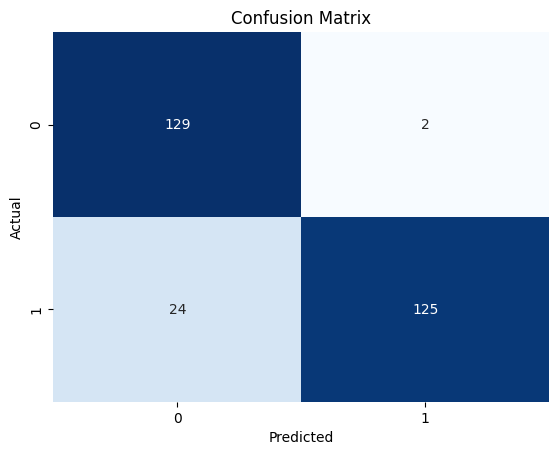

In [31]:
# Evaluate the model's performance

conf_matrix = confusion_matrix(y_test, y_pred)

mse= mean_squared_error(y_test, y_pred)

clf_rep = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

print("MSE:", mse)
print("Classification Report:\n", clf_rep)

#	Plot confusion matrix plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')

plt.ylabel('Actual')

plt.title('Confusion Matrix')
plt.show()

In [32]:
# Save the trained model to a file
dump(model, 'Project_Model.pkl')
dump(encoders, 'Project_Label_Encoders.pkl')

['Project_Label_Encoders.pkl']

In [33]:
loaded_model = load('Project_Model.pkl')
level_encoder = load('Project_Label_Encoders.pkl')